In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from altaipony.ffd import FFD

from funcs.flares import flare_factor
import astropy.units as u   

import glob
from astropy.io import fits 

import lightkurve as lk

from funcs.helper get_tess_orbital_phases, get_cheops_orbital_phases

# set default matplotlib fontsize to 13
plt.rcParams.update({'font.size': 13})


def get_flare_energy(ed, ederr, teff, tefferr, radius, radiuserr, wav, resp):
    """Sample the posterior distribution of the flare energy using random samples on ED, 
    and teff and radius with Gaussian errors.

    Parameters
    ----------
    ed : float
        The ED of the flare.
    ederr : float
        The error on the ED of the flare.
    teff : float
        The effective temperature of the star in K.
    tefferr : float
        The error on the effective temperature of the star in K.
    radius : float
        The radius of the star in solar radii.
    radiuserr : float
        The error on the radius of the star in solar radii.
    wav : array
        The wavelengths of the TESS response function.
    resp : array
        The response of the TESS response function.

    Returns
    -------
    mean_bol_energy : float
        The mean bolometric flare energy in erg.
    std_bol_energy : float
        The standard deviation of the bolometric flare energy in erg.
    """
    teff = np.random.normal(teff, tefferr, 500)
    radius = np.random.normal(radius, radiuserr, 500)
    eds = np.random.normal(ed, ederr, 500)
    # calculate the bolometric flare energy for each sample
    bol_energies = (flare_factor(teff.reshape((500,1)), 
                                 radius.reshape((500,1)), wav, resp,  
                                 tflare=10000) * np.random.choice(eds, 500) * u.s).value

    # calculate the mean and standard deviation of the bolometric flare energy
    mean_bol_energy = np.mean(bol_energies)
    std_bol_energy = np.std(bol_energies)

    return mean_bol_energy, std_bol_energy

In [25]:
# GET STELLAR AND PLANET PARAMETERS -----------------------------------------------------

hip67522params = pd.read_csv("../data/hip67522_params.csv")

period = hip67522params[hip67522params.param=="orbper_d"].val.values[0]
midpoint = hip67522params[hip67522params.param=="midpoint_BJD"].val.values[0]
teff = hip67522params[hip67522params.param=="teff_K"].val.values[0]
tefferr = hip67522params[hip67522params.param=="teff_K"].err.values[0]
radius = hip67522params[hip67522params.param=="radius_rsun"].val.values[0]
radiuserr = hip67522params[hip67522params.param=="radius_rsun"].err.values[0]

# ----------------------------------------------------------------------------------------


In [26]:
# GET TESS FLARES FROM ILIN+2024 AND CALCULATE ENERGIES -------------------------------------

# read the TESS flares
hip67522tess = pd.read_csv("../data/hip67522_tess_flares.csv")

# read TESS response function
tess_resp = pd.read_csv("../data/tess-response-function-v2.0.csv", skiprows=7, 
                        names=["wav", "resp"], header=None)
wav, resp = tess_resp.wav.values, tess_resp.resp.values

# calculate the flare energies
res = hip67522tess.apply(lambda x: get_flare_energy(x["ed_rec"], x["ed_rec_err"], teff, 
                                                    tefferr, radius, radiuserr, wav, resp),
                                                    axis=1)

# write res to two columns in a new dataframe using the right column names for the FFD object
hip67522tessffd = pd.DataFrame(res.values.tolist(), columns=["ed_rec", "ed_rec_err"])   
hip67522tessffd["phase"] = hip67522tess["phase"].values

# --------------------------------------------------------------------------------------------

# GET TESS OBSERVING TIME --------------------------------------------------------------------

tessphases, ttess01, ttess09, tot_obs_time_d_tess = get_tess_orbital_phases(period, split=0.1)

print(f"Observing time in first 10% of TESS light curve: {ttess01:.2f} days")
print(f"Observing time in last 90% of TESS light curve: {ttess09:.2f} days")
print(f"Total observing time of TESS light curve: {tot_obs_time_d_tess:.2f} days")

/tmp/ipykernel_6006/1524411576.py:41: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  lcs = lk.search_lightcurvefile("HIP 67522", mission="TESS",author="SPOC", exptime=120)
3% (562/18749) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
3% (562/18749) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
0% (41/18535) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
0% (41/18535) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
0% (80/18934) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
0% (80/18934) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


Observing time in first 10% of TESS light curve: 6.95 days
Observing time in last 90% of TESS light curve: 58.63 days
Total observing time of TESS light curve: 65.58 days


In [4]:
# READ IN CHEOPS FLARES ----------------------------------------------------------------------

cheopsflares = pd.read_csv('../results/cheops_flares.csv')

# convert some columns to be readable for the FFD object
cheopsflares["ed_rec"] = cheopsflares["mean_bol_energy"].values
cheopsflares["ed_rec_err"] = cheopsflares["std_bol_energy"].values
cheopsflares.ed_rec = cheopsflares.ed_rec.apply(lambda x: float(x[:-4]))
cheopsflares.ed_rec_err = cheopsflares.ed_rec_err.apply(lambda x: float(x[:-4]))

# --------------------------------------------------------------------------------------------



# READ IN CHEOPS OBSERVING PHASES ------------------------------------------------------------

cheopsphases, tcheops01, tcheops09, tot_obs_time_d_cheops = get_cheops_orbital_phases(period, midpoint, split=0.1)
print(f"Observing time in first 10% of CHEOPS light curve: {tcheops01:.2f} days")
print(f"Observing time in last 90% of CHEOPS light curve: {tcheops09:.2f} days")
print(f"Total CHEOPS observation time in days: {tot_obs_time_d_cheops}")

# --------------------------------------------------------------------------------------------


Observing time in first 10% of CHEOPS light curve: 5.01 days
Observing time in last 90% of CHEOPS light curve: 3.66 days
Total CHEOPS observation time in days: 8.674652777777778


In [5]:
# INITIATE FFDS -----------------------------------------------------------------------------------

tessffd = FFD(f=hip67522tessffd, tot_obs_time=tot_obs_time_d_tess, ID="HIP 67522")
cheopsffd = FFD(f=cheopsflares, tot_obs_time=tot_obs_time_d_cheops, ID="HIP 67522")

# --------------------------------------------------------------------------------------------

Setting ED with new values, size 12.
Setting frequency values with new values, size 12.
Setting frequency adjusted count values with new values, size 12.
Setting ED with new values, size 4.
Setting frequency values with new values, size 4.
Setting frequency adjusted count values with new values, size 4.


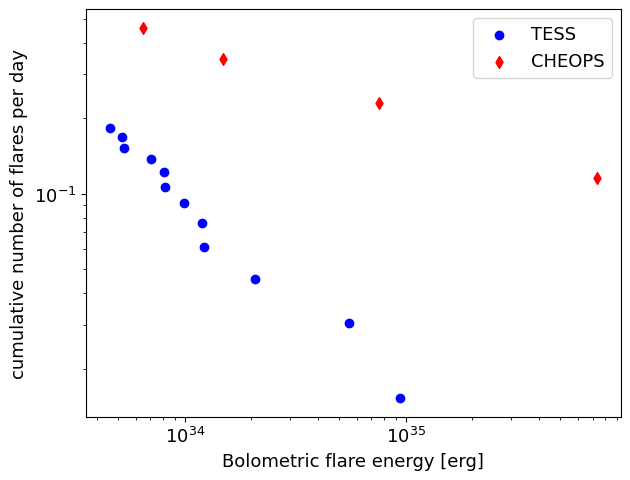

In [38]:
# PLOT THE FFDs -----------------------------------------------------------------------------------
plt.figure(figsize=(6.5, 5))
color = ["b","r"]
legend = ["TESS", "CHEOPS"]
marker = ["o", "d"]
for ffd, c, l, m in list(zip([tessffd, cheopsffd], 
                          color, legend, marker)):
    ed, freq, counts = ffd.ed_and_freq()
    plt.scatter(ed, freq, c=c, label=l, marker=m)
    
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Bolometric flare energy [erg]")
plt.ylabel("cumulative number of flares per day")
plt.legend()
plt.tight_layout()
plt.savefig("../plots/ffd/cheops_vs_tess_ffd.png", dpi=300) 

# --------------------------------------------------------------------------------------------


In [7]:
# GET FLARE PHASES and ENERGIES ----------------------------------------------------------------

# CHEOPS flare phases
cheopsflares["phase"] = ((cheopsflares["t_peak_BJD"] - midpoint) % period) / period

# make a DataFrame with the cheops and tess flare energies and phases
df = pd.concat([cheopsflares[["ed_rec", "ed_rec_err", "phase"]], hip67522tessffd[["ed_rec", "ed_rec_err", "phase"]]])

# --------------------------------------------------------------------------------------------


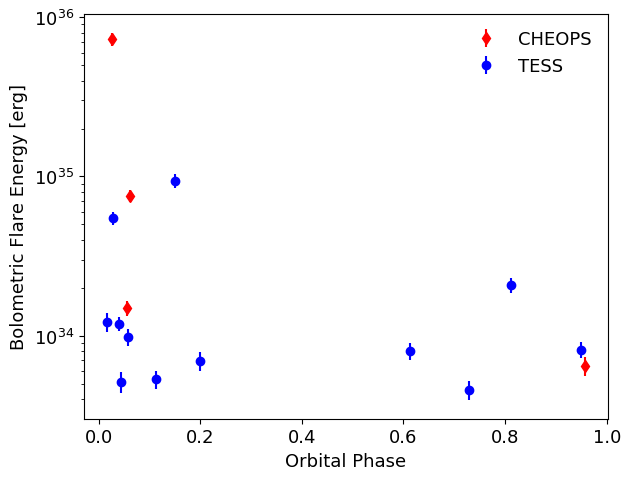

In [36]:
# PLOT FLARE ENERGIES against PHASE -----------------------------------------------------------

plt.figure(figsize=(6.5, 5))

plt.errorbar(cheopsflares["phase"], cheopsflares["ed_rec"], 
             yerr=cheopsflares['ed_rec_err'], c="r", label="CHEOPS", fmt="d" )
plt.errorbar(hip67522tessffd["phase"], hip67522tessffd["ed_rec"], 
             yerr = hip67522tessffd["ed_rec_err"], c="b", label="TESS", fmt="o")

plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel("Orbital Phase")
plt.ylabel("Bolometric Flare Energy [erg]")
plt.tight_layout()
plt.savefig("../plots/ffd/phase_vs_flare_energy.png", dpi=300)

# --------------------------------------------------------------------------------------------

In [9]:
# FIT A POWER LAW FOR EACH PHASE RANGE ----------------------------------------------------------

df10 = df[df["phase"]<0.1]
df90 = df[df["phase"]>0.1]
obs10 =  ttess01 + tcheops01
obs90 =  ttess09 + tcheops09 

ffd10 = FFD(f=df10, tot_obs_time=obs10, ID="phases 0-0.1")
ffd90 = FFD(f=df90, tot_obs_time=obs90, ID="phases 0.1-1")

color = ["b", "olive"]

bfas = []
for ffd, c in list(zip([ffd10, ffd90], color)):

    ed, freq, counts = ffd.ed_and_freq()
    # fit power law to each
    bfas.append(ffd.fit_powerlaw("mcmc"))

# --------------------------------------------------------------------------------------------



Setting ED with new values, size 8.
Setting frequency values with new values, size 8.
Setting frequency adjusted count values with new values, size 8.
/home/ilin/Documents/2024_03_HIP67522_CHEOPS/.venv/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/ilin/Documents/2024_03_HIP67522_CHEOPS/.venv/lib/python3.10/site-packages/altaipony/wheatland.py:313: RuntimeWarning: invalid value encountered in log
  f2 = M * np.log(alpha - 1)
100%|██████████| 500/500 [00:06<00:00, 71.62it/s]
Setting ED with new values, size 8.
Setting frequency values with new values, size 8.
Setting frequency adjusted count values with new values, size 8.
100%|██████████| 500/500 [00:01<00:00, 323.27it/s]


Setting ED with new values, size 8.
Setting frequency values with new values, size 8.
Setting frequency adjusted count values with new values, size 8.
Setting ED with new values, size 8.
Setting frequency values with new values, size 8.
Setting frequency adjusted count values with new values, size 8.


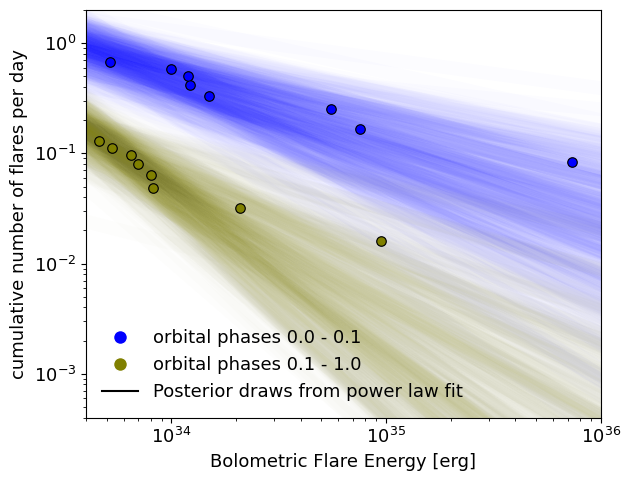

In [30]:


# MAKE A FIGURE OF THE FFD FITS ---------------------------------------------------------------

fig, ax = plt.subplots(figsize=(6.5, 5))
for ffd, c, BFA in list(zip([ffd10, ffd90], color, bfas)):
    ed, freq, counts = ffd.ed_and_freq()
    

    ffd.plot_mcmc_powerlaw(ax, BFA, c=c, custom_xlim=(4e33,1e36))

    ax.scatter(ed, freq, c="k", s=45, zorder=1000)
    ax.scatter(ed, freq, c=c, label=ffd.ID, s=25, zorder=1001)
 
# add legend handles manually
handles = [plt.Line2D([0], [0], marker='o', color='w', 
                      label='orbital phases 0.0 - 0.1', markerfacecolor='b', markersize=10),
              plt.Line2D([0], [0], marker='o', color='w', 
                         label='orbital phases 0.1 - 1.0', markerfacecolor='olive', markersize=10),
              plt.Line2D([0], [0], color='k', 
                         label='Posterior draws from power law fit')]

ax.legend(handles=handles, frameon=False, loc=3)
    
plt.xscale("log")   
plt.yscale("log")
plt.xlabel("Bolometric Flare Energy [erg]")
plt.ylabel("cumulative number of flares per day")
plt.xlim(4e33, 1e36)
plt.ylim(4e-4, 2)

plt.tight_layout()

plt.savefig("../plots/ffd/ffd_vs_phases.png")

# --------------------------------------------------------------------------------------------
